In [ ]:
import kagglehub
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, mean_squared_error
import matplotlib.pyplot as plt

SEED=69
torch.manual_seed(SEED)

# Preparing the regression dataframe

In [ ]:
# Converting CSV to DataFrame
nike_path = kagglehub.dataset_download("szrlee/stock-time-series-20050101-to-20171231")
nike_csv = os.path.join(nike_path, "NKE_2006-01-01_to_2018-01-01.csv")
nike_df = pd.read_csv(nike_csv)
nike_df.head()

100%|██████████| 3.03M/3.03M [00:00<00:00, 139MB/s]

Extracting files...


,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,10.85,10.92,10.67,10.74,18468800,NKE
1,2006-01-04,10.71,10.80,10.67,10.69,15832000,NKE
2,2006-01-05,10.69,10.83,10.69,10.76,9256000,NKE
3,2006-01-06,10.79,10.83,10.71,10.72,7573600,NKE
4,2006-01-09,10.72,10.98,10.72,10.88,10441600,NKE


In [ ]:
field_name = "High"

# Custom Time Series Dataset

In [ ]:
class CustomTimeSeriesDataset(Dataset):
  def __init__(self, data, window_length, num_outputs, stride):
    self.data = data
    self.window_length = window_length
    self.num_outputs = num_outputs
    self.stride = stride
    self.num_samples = (data.shape[0] - window_length - num_outputs) // stride + 1

  def __len__(self):
    return self.num_samples

  def __getitem__(self, idx):
    start_idx = idx * self.stride
    x = self.data[start_idx : start_idx + self.window_length]
    y = self.data[start_idx + self.window_length : start_idx + self.window_length + self.num_outputs]

    return x, y

In [ ]:
window_length = 10
num_outputs = 3
stride = 1

data_tensor = torch.tensor(nike_df[field_name].values, dtype=torch.float32)
time_series_dataset = CustomTimeSeriesDataset(data_tensor, window_length, num_outputs, stride)

sample_x, sample_y = time_series_dataset[0]
print("Sample X:", sample_x)
print("Sample Y:", sample_y)

Sample X: tensor([10.9200, 10.8000, 10.8300, 10.8300, 10.9800, 10.9800, 11.0100, 11.0200,
        10.8900, 10.8000])
Sample Y: tensor([10.6800, 10.6200, 10.7000])


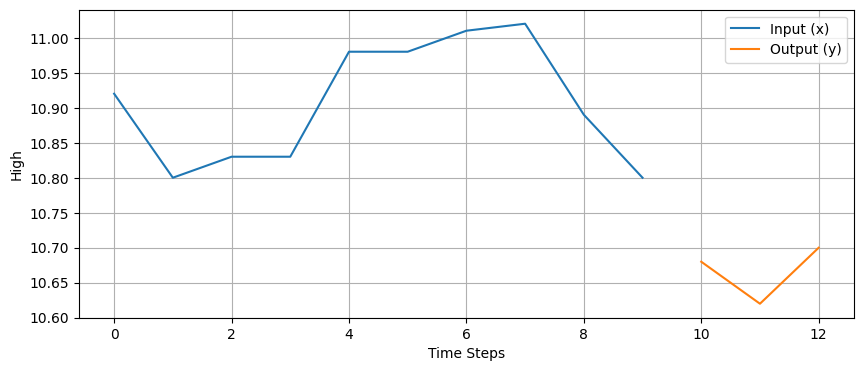

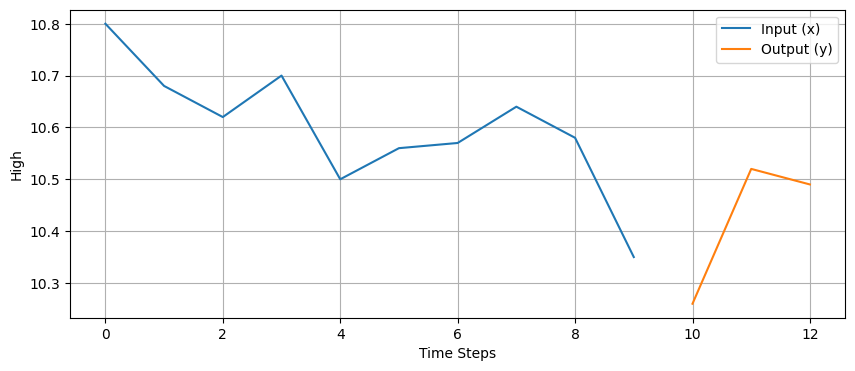

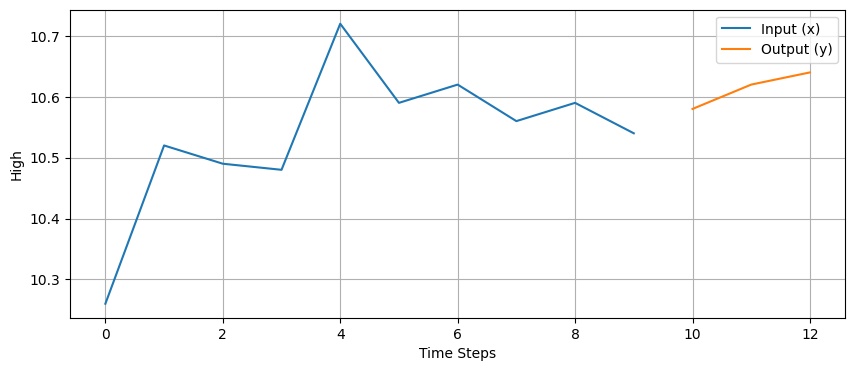

In [ ]:
sample_indices = [0, 9, 19]

for idx in sample_indices:
  x, y = time_series_dataset[idx]

  plt.figure(figsize=(10, 4))
  plt.plot(range(len(x)), x.cpu().numpy(), label="Input (x)")
  plt.plot(range(len(x), len(x) + len(y)), y.cpu().numpy(), label="Output (y)")
  plt.xlabel("Time Steps")
  plt.ylabel(field_name)
  plt.legend()
  plt.grid(True)
  plt.show()

# Training the regression model

In [ ]:
size_train = int(0.7 * len(time_series_dataset)) # Training Set
size_val = len(time_series_dataset) - size_train # Validation Set

train_dataset, val_dataset = torch.utils.data.random_split(time_series_dataset, [size_train, size_val])

print(len(train_dataset))
print(len(val_dataset))

2105
903


In [ ]:
class SimpleRegressionModel(nn.Module):
  def __init__(self, window_length, num_outputs):
    super().__init__()

    self.input_to_h1 = nn.Linear(window_length, 64)
    self.h1_to_h2 = nn.Linear(64, 32)
    self.h2_to_output = nn.Linear(32, num_outputs)

    self.relu = nn.ReLU()

  def forward(self, x):
    x = self.input_to_h1.forward(x)
    x = self.relu.forward(x)

    x = self.h1_to_h2(x)
    x = self.relu(x)

    x = self.h2_to_output(x) # No forward function

    return x

nike_model = SimpleRegressionModel(window_length, num_outputs)

In [ ]:
loss_function = nn.MSELoss() # MSE Loss for Regression Problems
optimizer = torch.optim.Adam(nike_model.parameters(), lr=0.001)

In [ ]:
batch_size = 32

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
def train_fn(model, optimizer, loss_fn, train_dataloader, val_dataloader):
  ave_loss = 0.0
  val_loss = 0.0

  # ave_loss
  model.train()
  for x, y in train_dataloader:
    predictions = model.forward(x)

    loss = loss_fn(predictions, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    ave_loss += loss.item()

  ave_loss = ave_loss / len(train_dataloader)

  # val_loss
  model.eval()

  for x, y in val_dataloader:
    predictions = model.forward(x)
    loss = loss_fn(predictions, y)

    val_loss += loss.item()

  val_loss = val_loss / len(val_dataloader)

  return ave_loss, val_loss

In [ ]:
epochs = 100

for i in range(epochs):
  ave_loss, val_loss = train_fn(nike_model, optimizer, loss_function, train_dataloader, val_dataloader)

  print(f"Epoch {i+1}: Ave Loss: {ave_loss} Val Loss: {val_loss}")

Epoch 1: Ave Loss: 319.97714016834897 Val Loss: 2.2986539499513032
Epoch 2: Ave Loss: 1.322358633984219 Val Loss: 1.0163389002454692
Epoch 3: Ave Loss: 0.9458534071842829 Val Loss: 1.0316197163072125
Epoch 4: Ave Loss: 0.9449968265764641 Val Loss: 1.0330281545375954
Epoch 5: Ave Loss: 0.9429148139827179 Val Loss: 1.0314174952178166
Epoch 6: Ave Loss: 0.9404366745641737 Val Loss: 1.0262610789003044
Epoch 7: Ave Loss: 0.9373194582083009 Val Loss: 1.0196379094288266
Epoch 8: Ave Loss: 0.9338745398051811 Val Loss: 1.0134386409973275
Epoch 9: Ave Loss: 0.9303910368771264 Val Loss: 1.0081490699587197
Epoch 10: Ave Loss: 0.9269567118449644 Val Loss: 1.0034266083404935
Epoch 11: Ave Loss: 0.923540936274962 Val Loss: 0.9987297325298704
Epoch 12: Ave Loss: 0.920064203441143 Val Loss: 0.9935010096122479
Epoch 13: Ave Loss: 0.916409302389983 Val Loss: 0.9872798703867813
Epoch 14: Ave Loss: 0.9124188341877677 Val Loss: 0.9798745245769106
Epoch 15: Ave Loss: 0.9079225058808471 Val Loss: 0.9715707466

# Vanilla method

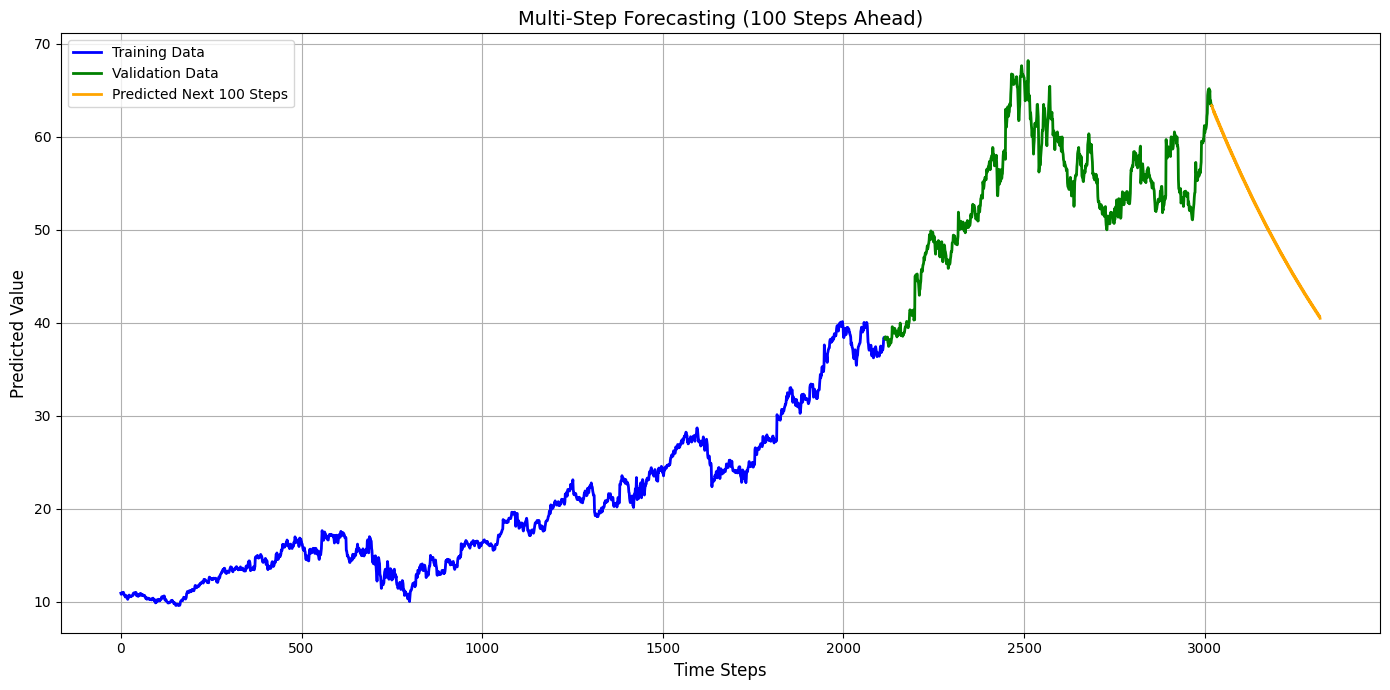

In [ ]:
n = 100
nike_model.eval()

predicted_sequence_input = data_tensor.tolist()
len_total_data = len(data_tensor)
len_train_data = int(0.7 * len_total_data)
len_val_data = len_total_data - len_train_data

for _ in range(n):
    input_sequence = torch.tensor(predicted_sequence_input[-window_length:], dtype=torch.float32)
    predictions = nike_model.forward(input_sequence)

    predicted_sequence_input.extend(predictions.tolist())

plt.figure(figsize=(14, 7))

# Plot training data
plt.plot(range(len_train_data), data_tensor[:len_train_data].numpy(), label="Training Data", color="blue", linewidth=2)

# Plot validation data
plt.plot(range(len_train_data, len_total_data), data_tensor[len_train_data:].numpy(), label="Validation Data", color="green", linewidth=2)

# Plot predicted data (continuation)
plt.plot(
    range(len_total_data -1, len(predicted_sequence_input)),
    predicted_sequence_input[len_total_data -1:],
    label=f"Predicted Next {n} Steps",
    color="orange",
    linewidth=2
)

plt.title(f"Multi-Step Forecasting ({n} Steps Ahead)", fontsize=14)
plt.xlabel("Time Steps", fontsize=12)
plt.ylabel("Predicted Value", fontsize=12)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Random Walk Noise

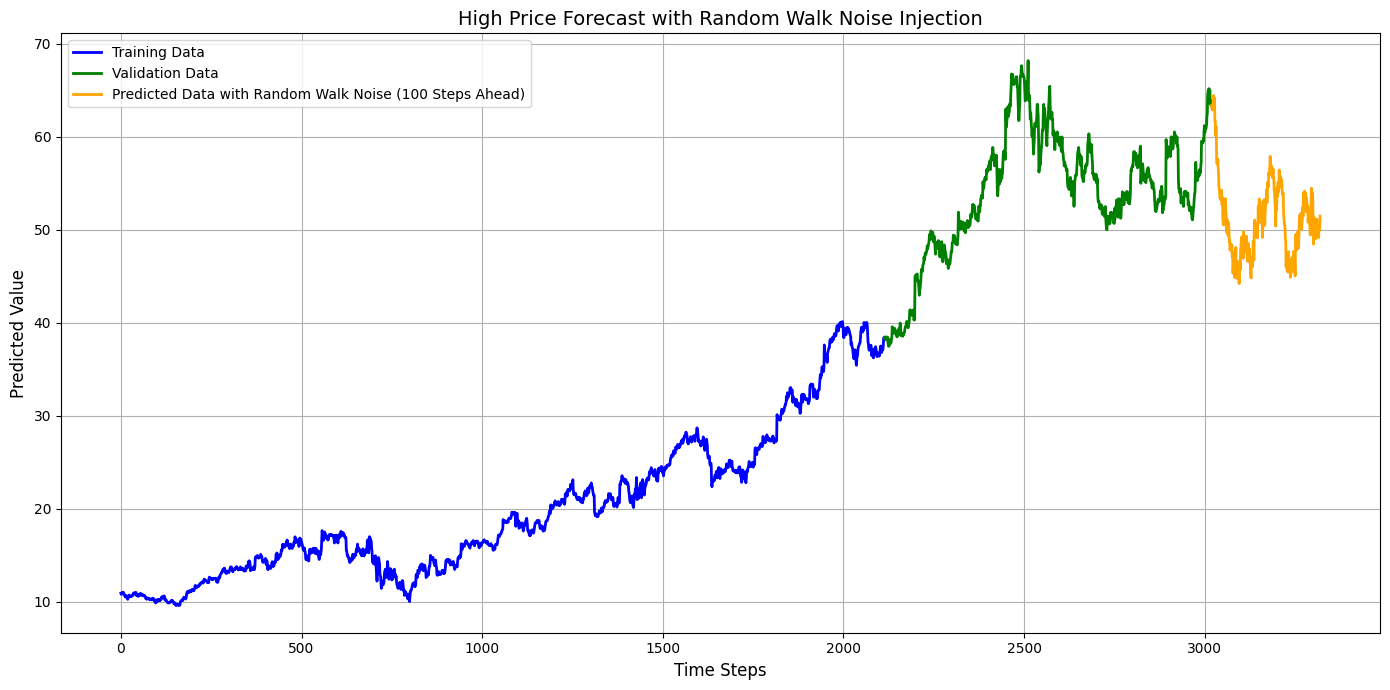

In [ ]:
# with random walk noise
n = 100

nike_model.eval()

predicted_sequence_random = data_tensor.tolist()

noise_std = 1

for _ in range(n):
    input_sequence = torch.tensor(predicted_sequence_random[-window_length:], dtype=torch.float32)
    predictions = nike_model.forward(input_sequence)

    # Add random walk noise
    white_noise = np.random.normal(0, noise_std, num_outputs)
    random_walk = np.cumsum(white_noise)

    predictions = predictions + torch.tensor(random_walk, dtype=torch.float32)

    predicted_sequence_random.extend(predictions.tolist())

# --- Plotting ---
plt.figure(figsize=(14, 7))

# Plot training data
plt.plot(range(len_train_data), data_tensor[:len_train_data].numpy(), label="Training Data", color="blue", linewidth=2)

# Plot validation data
plt.plot(range(len_train_data, len_total_data), data_tensor[len_train_data:].numpy(), label="Validation Data", color="green", linewidth=2)

# Plot predicted data with noise
plt.plot(
    range(len(data_tensor) - 1, len(predicted_sequence_random)),
    predicted_sequence_random[len(data_tensor) - 1:],
    label=f"Predicted Data with Random Walk Noise ({n} Steps Ahead)",
    color="orange",
    linewidth=2
)

# Labels and title
plt.title("High Price Forecast with Random Walk Noise Injection", fontsize=14)
plt.xlabel("Time Steps", fontsize=12)
plt.ylabel("Predicted Value", fontsize=12)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Weight Noise

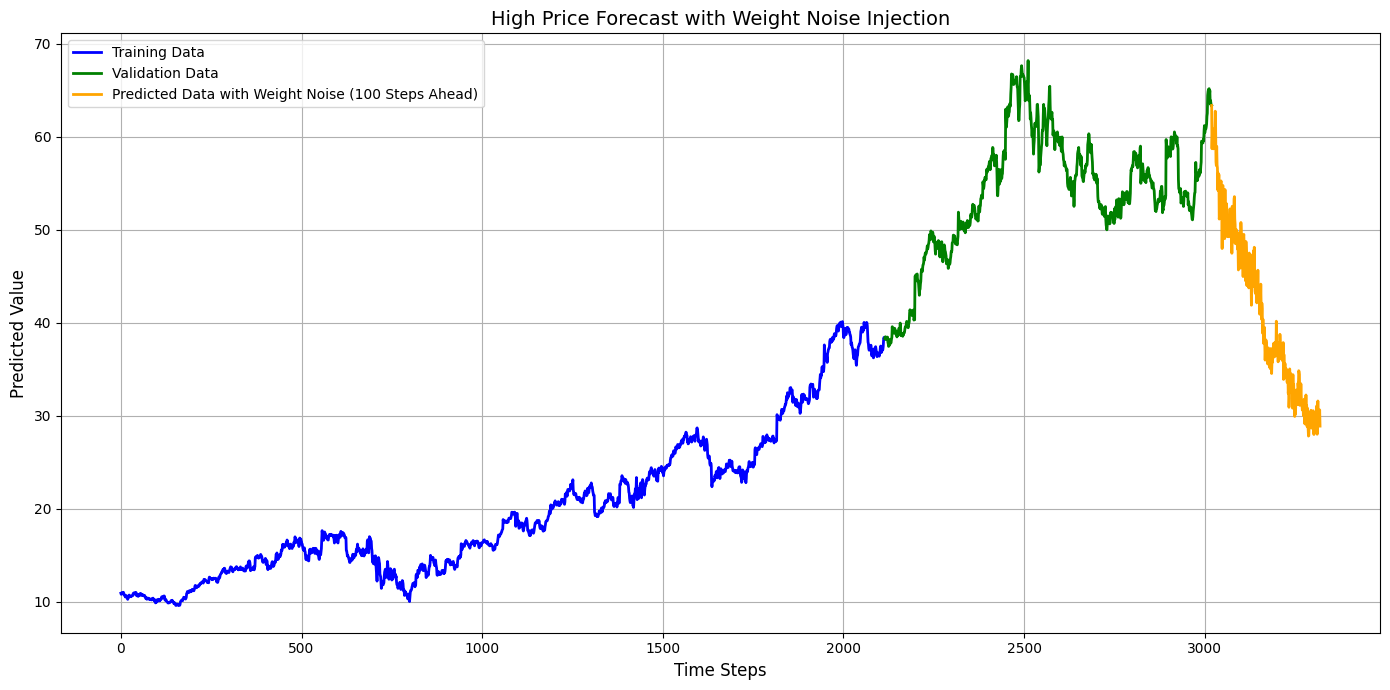

In [ ]:
# with weight noise
n = 100
nike_model.eval()

predicted_sequence_weight = data_tensor.tolist()
noise_std = 0.01  # standard deviation for weight noise

for _ in range(n):
    input_sequence = torch.tensor(predicted_sequence_weight[-window_length:], dtype=torch.float32)
    original_weights = [param.detach().clone() for param in nike_model.parameters()]

    with torch.no_grad():
        for param in nike_model.parameters():
            noise = torch.randn_like(param) * noise_std
            param.add_(noise)

    with torch.no_grad():
        predictions = nike_model.forward(input_sequence)

    with torch.no_grad():
        for param, orig in zip(nike_model.parameters(), original_weights):
            param.copy_(orig)

    predicted_sequence_weight.extend(predictions.tolist())

# --- Plotting ---
plt.figure(figsize=(14, 7))

# Plot training data
plt.plot(range(len_train_data), data_tensor[:len_train_data].numpy(), label="Training Data", color="blue", linewidth=2)

# Plot validation data
plt.plot(range(len_train_data, len_total_data), data_tensor[len_train_data:].numpy(), label="Validation Data", color="green", linewidth=2)

# Predicted data with weight noise
plt.plot(
    range(len(data_tensor) - 1, len(predicted_sequence_weight)),
    predicted_sequence_weight[len(data_tensor) - 1:],
    label=f"Predicted Data with Weight Noise ({n} Steps Ahead)",
    color="orange",
    linewidth=2
)

# Labels, title, and legend
plt.title("High Price Forecast with Weight Noise Injection", fontsize=14)
plt.xlabel("Time Steps", fontsize=12)
plt.ylabel("Predicted Value", fontsize=12)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


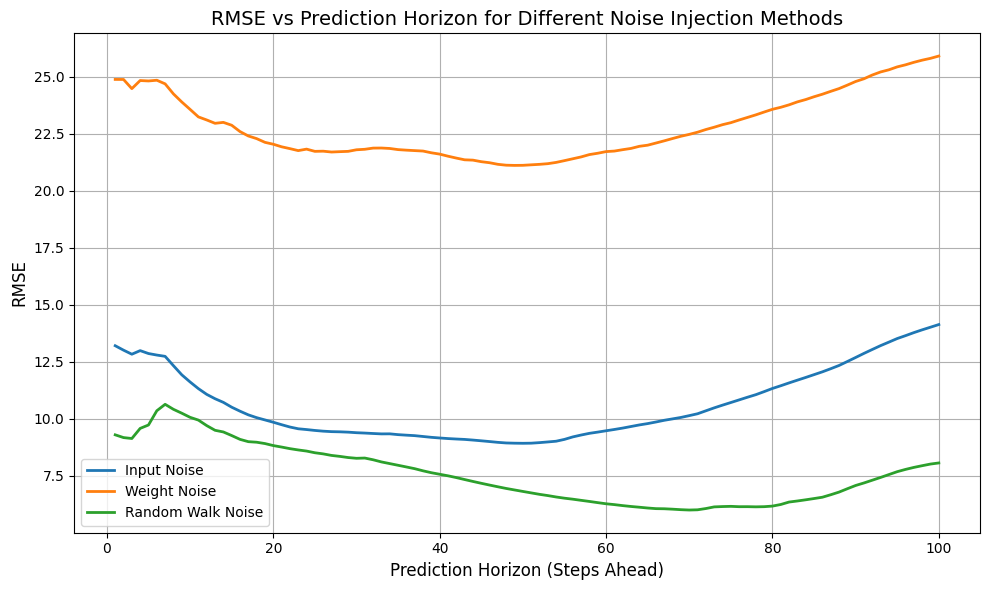

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Assume these are the final predicted sequences from your three methods
pred_input_noise = np.array(predicted_sequence_input[-n:])       # from input noise method
pred_weight_noise = np.array(predicted_sequence_weight[-n:])     # from weight noise method
pred_random_walk = np.array(predicted_sequence_random[-n:])      # from random walk noise method

# True values for comparison
true_values = data_tensor[-n:].numpy()

# Compute RMSE for each horizon
def compute_rmse(true_vals, pred_vals):
    rmse_list = []
    for horizon in range(1, n + 1):
        rmse = np.sqrt(mean_squared_error(true_vals[:horizon], pred_vals[:horizon]))
        rmse_list.append(rmse)
    return rmse_list

# RMSE for each method
rmse_input = compute_rmse(true_values, pred_input_noise)
rmse_weight = compute_rmse(true_values, pred_weight_noise)
rmse_random = compute_rmse(true_values, pred_random_walk)

# --- Plot RMSE Comparison ---
plt.figure(figsize=(10, 6))
plt.plot(range(1, n + 1), rmse_input, label="Input Noise", linewidth=2)
plt.plot(range(1, n + 1), rmse_weight, label="Weight Noise", linewidth=2)
plt.plot(range(1, n + 1), rmse_random, label="Random Walk Noise", linewidth=2)

plt.xlabel("Prediction Horizon (Steps Ahead)", fontsize=12)
plt.ylabel("RMSE", fontsize=12)
plt.title("RMSE vs Prediction Horizon for Different Noise Injection Methods", fontsize=14)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Preparing the classification dataframe

In [ ]:
churn_path = kagglehub.dataset_download("blastchar/telco-customer-churn")
churn_csv = os.path.join(churn_path, os.listdir(churn_path)[0])
churn_df = pd.read_csv(churn_csv)
churn_df.head()

Using Colab cache for faster access to the 'telco-customer-churn' dataset.


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
drop_cols = ["customerID"]

churn_df_clean = churn_df.drop(columns=drop_cols, axis=1)
churn_df_clean

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


In [ ]:
churn_df_clean["TotalCharges"] = pd.to_numeric(churn_df_clean["TotalCharges"], errors="coerce")

categorical_columns = churn_df_clean.select_dtypes(include=["object", "category", "string", "bool"]).columns.tolist()

churn_df_clean = pd.get_dummies(churn_df_clean, columns=categorical_columns, drop_first=False, dtype=int)
churn_df_clean

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,...,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_No,Churn_Yes
0,0,1,29.85,29.85,1,0,0,1,1,0,...,0,0,0,1,0,0,1,0,1,0
1,0,34,56.95,1889.50,0,1,1,0,1,0,...,1,0,1,0,0,0,0,1,1,0
2,0,2,53.85,108.15,0,1,1,0,1,0,...,0,0,0,1,0,0,0,1,0,1
3,0,45,42.30,1840.75,0,1,1,0,1,0,...,1,0,1,0,1,0,0,0,1,0
4,0,2,70.70,151.65,1,0,1,0,1,0,...,0,0,0,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,24,84.80,1990.50,0,1,0,1,0,1,...,1,0,0,1,0,0,0,1,1,0
7039,0,72,103.20,7362.90,1,0,0,1,0,1,...,1,0,0,1,0,1,0,0,1,0
7040,0,11,29.60,346.45,1,0,0,1,0,1,...,0,0,0,1,0,0,1,0,1,0
7041,1,4,74.40,306.60,0,1,0,1,1,0,...,0,0,0,1,0,0,0,1,0,1


In [ ]:
churn_df_missing_rows =  churn_df_clean[churn_df_clean.isnull().any(axis=1)]
churn_df_missing_rows

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,...,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_No,Churn_Yes
488,0,0,52.55,NaN,1,0,0,1,0,1,...,0,1,0,1,1,0,0,0,1,0
753,0,0,20.25,NaN,0,1,1,0,0,1,...,0,1,1,0,0,0,0,1,1,0
936,0,0,80.85,NaN,1,0,0,1,0,1,...,0,1,1,0,0,0,0,1,1,0
1082,0,0,25.75,NaN,0,1,0,1,0,1,...,0,1,1,0,0,0,0,1,1,0
1340,0,0,56.05,NaN,1,0,0,1,0,1,...,0,1,1,0,0,1,0,0,1,0
3331,0,0,19.85,NaN,0,1,0,1,0,1,...,0,1,1,0,0,0,0,1,1,0
3826,0,0,25.35,NaN,0,1,0,1,0,1,...,0,1,1,0,0,0,0,1,1,0
4380,0,0,20.00,NaN,1,0,0,1,0,1,...,0,1,1,0,0,0,0,1,1,0
5218,0,0,19.70,NaN,0,1,0,1,0,1,...,1,0,0,1,0,0,0,1,1,0
6670,0,0,73.35,NaN,1,0,0,1,0,1,...,0,1,1,0,0,0,0,1,1,0


In [ ]:
class Imputer():
  def __init__(self, method, feature):
    self.method = method
    self.feature = feature

  def _mean(self, df):
    mean = df[self.feature].mean()
    df[self.feature] = df[self.feature].fillna(mean)
    return df

  def _median(self, df):
    median = df[self.feature].median()
    df[self.feature] = df[self.feature].fillna(median)
    return df

  def impute(self, df):
    imputers = {"mean": self._mean, "median": self._median}
    df = imputers[self.method](df)
    return df

In [ ]:
imputer = Imputer(method="mean", feature="TotalCharges")
df_clean = imputer.impute(churn_df_clean)
df_clean.isnull().sum()

,0
SeniorCitizen,0
tenure,0
MonthlyCharges,0
TotalCharges,0
gender_Female,0
gender_Male,0
Partner_No,0
Partner_Yes,0
Dependents_No,0
Dependents_Yes,0


In [ ]:
class Scaler():
    numerical_features = ["tenure", "MonthlyCharges", "TotalCharges"]

    def __init__(self, method):
        self.method = method

    def _minmax(self, df):
        scaler = MinMaxScaler()
        df[self.numerical_features] = scaler.fit_transform(df[self.numerical_features])
        return df

    def _zscore(self, df):
        scaler = StandardScaler()
        df[self.numerical_features] = scaler.fit_transform(df[self.numerical_features])
        return df

    def _robust(self, df):
        scaler = RobustScaler()
        df[self.numerical_features] = scaler.fit_transform(df[self.numerical_features])
        return df

    def transform(self, df):
        scalers = {
            "minmax": self._minmax,
            "zscore": self._zscore,
            "robust": self._robust
        }
        df_scaled = scalers[self.method](df)
        return df_scaled

In [ ]:
minmax_scaler = Scaler(method="minmax")
minmax_df = minmax_scaler.transform(churn_df_clean.copy())
minmax_df

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,...,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_No,Churn_Yes
0,0,0.013889,0.115423,0.001275,1,0,0,1,1,0,...,0,0,0,1,0,0,1,0,1,0
1,0,0.472222,0.385075,0.215867,0,1,1,0,1,0,...,1,0,1,0,0,0,0,1,1,0
2,0,0.027778,0.354229,0.010310,0,1,1,0,1,0,...,0,0,0,1,0,0,0,1,0,1
3,0,0.625000,0.239303,0.210241,0,1,1,0,1,0,...,1,0,1,0,1,0,0,0,1,0
4,0,0.027778,0.521891,0.015330,1,0,1,0,1,0,...,0,0,0,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,0.333333,0.662189,0.227521,0,1,0,1,0,1,...,1,0,0,1,0,0,0,1,1,0
7039,0,1.000000,0.845274,0.847461,1,0,0,1,0,1,...,1,0,0,1,0,1,0,0,1,0
7040,0,0.152778,0.112935,0.037809,1,0,0,1,0,1,...,0,0,0,1,0,0,1,0,1,0
7041,1,0.055556,0.558706,0.033210,0,1,0,1,1,0,...,0,0,0,1,0,0,0,1,0,1


In [ ]:
minmax_df_final = minmax_df.drop(columns="Churn_No", axis=1)

In [ ]:
class ChurnDataset(Dataset):
  def __init__(self, df):
    self.df = df
    self.x = torch.tensor(df.drop(columns=["Churn_Yes"]).values, dtype=torch.float32) # Convert feature columns to tensor

    self.y = torch.zeros(
        (len(df), 2),
        dtype=torch.float32
    )

    self.labels = torch.tensor(df["Churn_Yes"].values, dtype=torch.long)
    self.y[torch.arange(len(self.labels)), self.labels] = 1.0

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    return (self.x[idx], self.y[idx])

dataset = ChurnDataset(minmax_df_final)
dataset[0]

(tensor([0.0000, 0.0139, 0.1154, 0.0013, 1.0000, 0.0000, 0.0000, 1.0000, 1.0000,
         0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000, 0.0000,
         1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 1.0000, 0.0000, 0.0000,
         1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
         1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000]),
 tensor([1., 0.]))

# Training the classification model

In [ ]:
churn_size_train = int(0.8 * len(dataset)) # Training Set
churn_size_val = len(dataset) - churn_size_train # Validation Set

churn_train_dataset, churn_val_dataset = torch.utils.data.random_split(dataset, [churn_size_train, churn_size_val])

print(len(churn_train_dataset))
print(len(churn_val_dataset))

5634
1409


In [ ]:
class ChurnNeuralNetwork(nn.Module):
  def __init__(self):
    super().__init__()

    self.input_to_h1 = nn.Linear(45, 35)
    self.h1_to_h2 = nn.Linear(35, 25)
    self.h2_to_h3 = nn.Linear(25, 15)
    self.h3_to_h4 = nn.Linear(15, 5)
    self.h4_to_output = nn.Linear(5, 2)

    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    x = self.input_to_h1.forward(x)
    x = self.sigmoid.forward(x)

    x = self.h1_to_h2.forward(x)
    x = self.sigmoid.forward(x)

    x = self.h2_to_h3.forward(x)
    x = self.sigmoid.forward(x)

    x = self.h3_to_h4.forward(x)
    x = self.sigmoid(x)

    x = self.h4_to_output(x)

    return x

churn_model = ChurnNeuralNetwork()

In [ ]:
loss_function = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(churn_model.parameters(), lr=learning_rate)
batch_size = 32

train_dataloader = DataLoader(churn_train_dataset, batch_size=batch_size, shuffle=False)
val_dataloader = DataLoader(churn_val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
def train_churn_fn(model, optimizer, loss_fn, train_dataloader, val_dataloader):
  model.train()

  ave_train_loss = 0.0

  for x, y in train_dataloader:

    predictions = model.forward(x)
    loss = loss_fn(predictions, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    ave_train_loss += loss.item()

  ave_train_loss /= len(train_dataloader)

  model.eval()

  ave_val_loss = 0.0

  for x, y in val_dataloader:

    predictions = model.forward(x)
    loss = loss_fn(predictions, y)

    ave_val_loss += loss.item()

  ave_val_loss /= len(val_dataloader)

  return ave_train_loss, ave_val_loss

In [ ]:
epochs = 100

for i in range(epochs):
  ave_train_loss, ave_val_loss = train_churn_fn(churn_model, optimizer, loss_function, train_dataloader, val_dataloader)

  print(f"Epoch {i+1}: Ave Loss: {ave_train_loss} Val Loss: {ave_val_loss}")

Epoch 1: Ave Loss: 0.6044355122383032 Val Loss: 0.5804772052499984
Epoch 2: Ave Loss: 0.572232756069151 Val Loss: 0.5756185617711809
Epoch 3: Ave Loss: 0.5618423304315341 Val Loss: 0.5515796661376953
Epoch 4: Ave Loss: 0.5143011863959037 Val Loss: 0.48118352823787264
Epoch 5: Ave Loss: 0.46521049468530773 Val Loss: 0.45123215781317816
Epoch 6: Ave Loss: 0.452702019847719 Val Loss: 0.44339638385507796
Epoch 7: Ave Loss: 0.44928260770557965 Val Loss: 0.43953662514686587
Epoch 8: Ave Loss: 0.4459855298874742 Val Loss: 0.43286267618338264
Epoch 9: Ave Loss: 0.4422713309358069 Val Loss: 0.4302094260851542
Epoch 10: Ave Loss: 0.43973954661754566 Val Loss: 0.42822454935974547
Epoch 11: Ave Loss: 0.43728352847409113 Val Loss: 0.4261923568116294
Epoch 12: Ave Loss: 0.4348541094926791 Val Loss: 0.4241348170571857
Epoch 13: Ave Loss: 0.43247479175106956 Val Loss: 0.42214999232027267
Epoch 14: Ave Loss: 0.430172362990972 Val Loss: 0.4203365511364407
Epoch 15: Ave Loss: 0.42797566840877643 Val Loss

In [ ]:
churn_model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for xb, yb in val_dataloader:
        outputs = churn_model(xb)
        preds = torch.round(torch.sigmoid(outputs))
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(yb.cpu().numpy())

f1_org = f1_score(all_labels, all_preds, average=None)

print("F1 Score (Churn = 1):", f1_org[1])

F1 Score (Churn = 1): 0.64
